In [1]:
from IPython.utils import io
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion


with io.capture_output() as captured:
  if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
      print("Python3 is needed!");
      print("How to fix: Runtime/Change_runtime_type/Python 3");
      sys.exit()
      
  try:
      from dolfin import *; from mshr import *
  except ImportError as e:
      !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
      !add-apt-repository -y ppa:fenics-packages/fenics
      !apt-get update -qq
      !apt install -y --no-install-recommends fenics
      from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files

dolfin version: 2019.1.0


In [2]:
import dolfin
import mshr
import matplotlib.pyplot as plt
%matplotlib inline

#Helmholtz equation with Robin boundary conditions
def Helmholtz(mesh, frequency, xs, sigma=Constant(0), c=343):
    
    # squared wavenumber
    k2 = Constant(2*pi*frequency/c)**2
    
    # define function space
    V = VectorFunctionSpace(mesh, "CG", 1, dim=2) #dim=2 makes it like V=W*W

    # define variational problem/weak form as a vector
    (u_r, u_i) = TrialFunction(V)
    (v_r, v_i) = TestFunction(V)

    a_r = ( k2 * inner(u_r,v_r) - k2 * inner(u_i,v_i) - inner(grad(u_r), grad(v_r)) + inner(grad(u_i), grad(v_i)) ) * dx   - sigma*inner(u_r, v_i) * ds - sigma*inner(u_i, v_r) * ds
    a_i = ( k2 * inner(u_r,v_i) + k2 * inner(u_i,v_r) - inner(grad(u_r), grad(v_i)) - inner(grad(u_i), grad(v_r)) ) * dx  + sigma*inner(u_r, v_r) * ds - sigma*inner(u_i, v_i) * ds
    L_r = Constant(0) * v_r * dx
    L_i = Constant(0) * v_i * dx

    a = a_r + a_i
    L = L_r + L_i
    A, b = assemble_system(a, L)

    # define inhomogenity
    delta = PointSource(V.sub(0), xs, -1)  # negative amplitude accounts for -v in inhomogeneous wave equation (1/c^2)(u''-grad^2u)=-v
    delta.apply(b)

    # compute solution
    u = Function(V)
    solve(A, u.vector(), b)
    (u_r, u_i) = split(u)
    
    return u_r

In [3]:
def plot_solution(u):
    '''plots solution of FEM-based simulation'''
    fig = plt.figure(figsize=(10,10))
    fig = plot(u)
    plt.title(r'$u(\mathbf{x},\omega)$') #x is vector
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.colorbar(fig, fraction=0.04, pad=0.04);

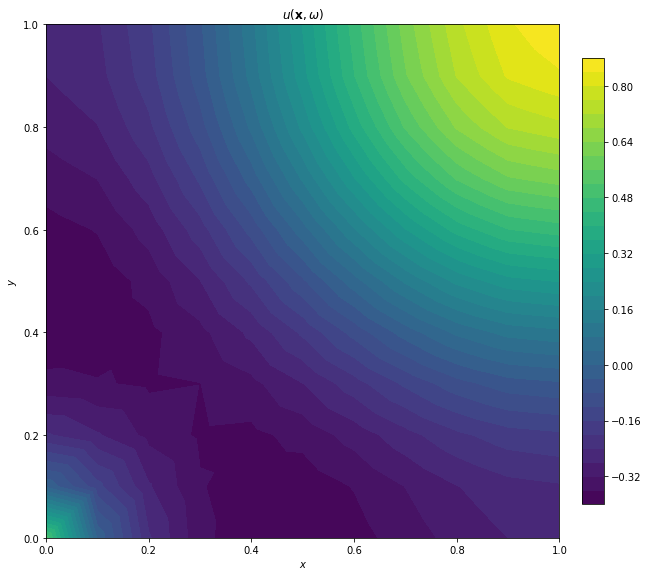

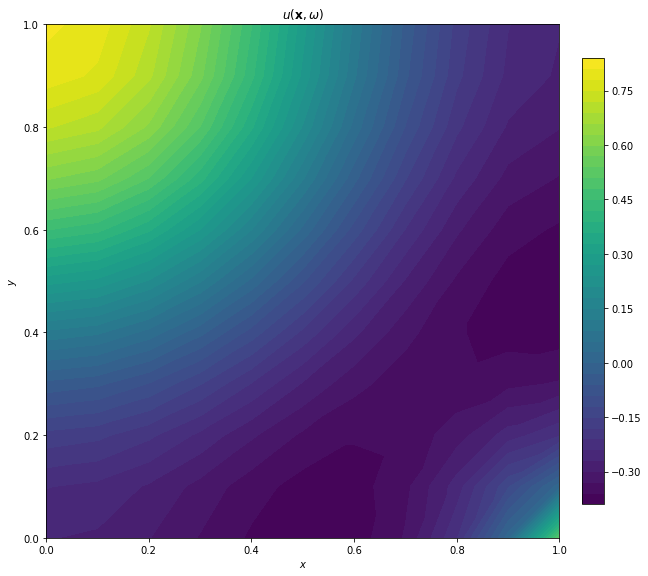

In [4]:
f=200 #frequency
xs=Point(0,0) #point source which gives you center of solution
xs1=Point(1,0)

mesh=UnitSquareMesh(10,10)
# compute solution for sigma=0
u = Helmholtz(mesh, f, xs, sigma=Constant(0))
u1 = Helmholtz(mesh, f, xs1, sigma=Constant(0))
# plot solution
plot_solution(u)
plot_solution(u1)

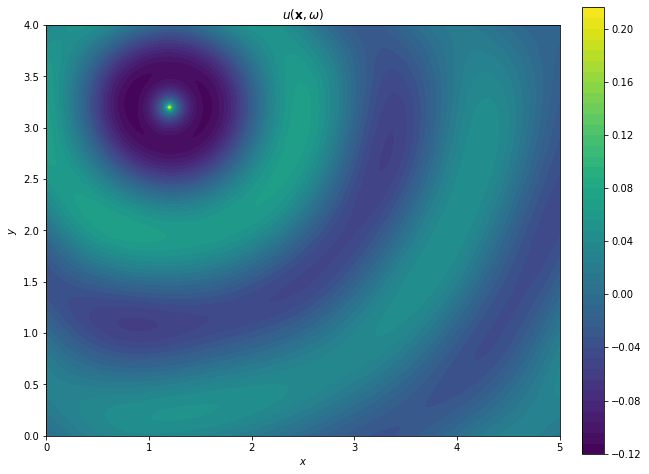

In [5]:

xs_1 = Point(1.2, 3.2)  # new source position

# define geometry and mesh, namely rectangular mesh
mesh1 = RectangleMesh(Point(0, 0), Point(5, 4), 200, 200, "right/left")
# compute solution with rectangle mesh
u2 = Helmholtz(mesh1, f, xs_1, sigma=Constant(2*dolfin.pi*f/343))

# plot sound field
plot_solution(u2)
plt.title(r'$u(\mathbf{x}, \omega)$');

Text(0.5, 1.0, '$|u(\\mathbf{x}, \\omega)$|')

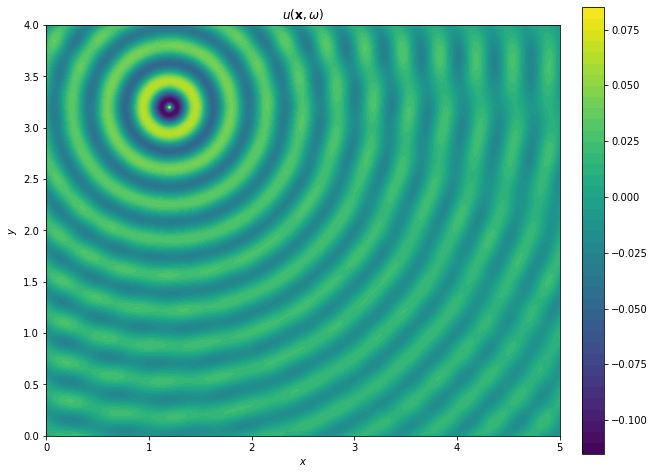

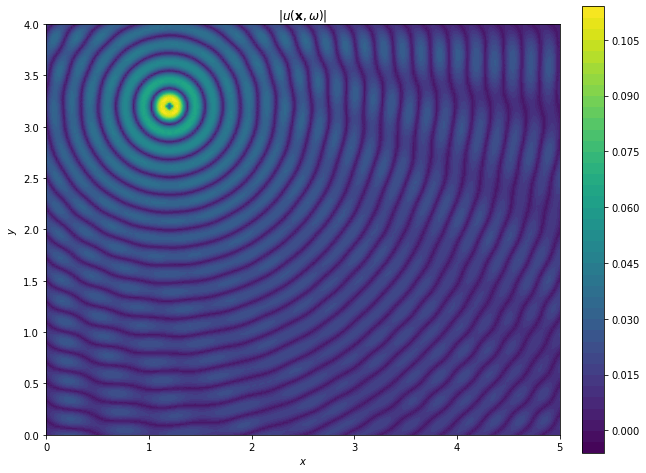

In [14]:
freq=1000
u3 = Helmholtz(mesh1, freq, xs_1, sigma=Constant(2*pi*freq/343))
plot_solution(u3) #higher frequency by 1000 with rectangular mesh
plot_solution(abs(u3))
plt.title(r'$|u(\mathbf{x}, \omega)$|') #absolute value